# Detección de operaciones fraudulentas en tarjetas de crédito

In [ ]:
COLAB = True

**Importamos librerías:**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

import matplotlib.pyplot as plt

**Función auxiliar:**

In [ ]:
from matplotlib.ticker import MaxNLocator

def plot_history(historia):
    f = plt.figure(figsize=(4,4))
    h = historia.history
    aux = range(1,len(h["loss"])+1)
    mejor_epoca = np.argmin(h["val_loss"])
    plt.plot(aux, h["loss"], label="entrenamiento")
    plt.plot(aux, h["val_loss"], label="validación")
    plt.plot(mejor_epoca+1, h["val_loss"][mejor_epoca], 'or')
    plt.title('Loss', fontsize=18)
    plt.xlabel('Época', fontsize=18)
    plt.xticks(fontsize=12); plt.yticks(fontsize=12)
    plt.legend()
    f.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

**Descargamos los datos:**

In [ ]:
if COLAB:
  aux = "'https://drive.usercontent.google.com/download?id=127ILG_gRU63_5ob4Ri-kRuqjUVII-lvW&export=download&confirm=t&uuid=5625bb98-79b8-42f1-8ca7-65dc5fac66f3'"
  aux = "'https://drive.usercontent.google.com/download?id=11Z6euKjG8w5n57kjvkqpqt-HPVEc2Rkw&export=download&confirm=t&uuid=9c1afc5f-dd87-4248-ba0f-6d10c09c34d2'"
  !wget $aux -O ./creditcard.csv.zip
  !unzip -qq ./creditcard.csv.zip

--2024-05-13 15:56:52--  https://drive.usercontent.google.com/download?id=11Z6euKjG8w5n57kjvkqpqt-HPVEc2Rkw&export=download&confirm=t&uuid=9c1afc5f-dd87-4248-ba0f-6d10c09c34d2
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 108.177.98.132, 2607:f8b0:400e:c06::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|108.177.98.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44885780 (43M) [application/octet-stream]
Saving to: ‘./creditcard.csv.zip’

./creditcard.csv.zi 100%[===================>]  42.81M  80.6MB/s    in 0.5s    

2024-05-13 15:56:53 (80.6 MB/s) - ‘./creditcard.csv.zip’ saved [44885780/44885780]



In [ ]:
# here the import csv file as a pandas dataframe
df = pd.read_csv("./creditcard.csv")

In [ ]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Descripción del dataset

El dataset contiene transacciones realizadas con tarjetas de crédito en septiembre de 2013 por clientes europeos. Este dataset contiene transacciones que se produjeron en dos días, donde tenemos 492 fraudes de 284807 transacciones. El conjunto de datos está muy desbalanceado, ya que la clase positiva (fraude) representa el 0.172% de todas las transacciones.

El dataset contiene solo variables de entrada numéricas que son el resultado de una transformación PCA.
Por motivos de confidencialidad, no se facilitan las variables originales ni más información sobre los datos. Las variables V1, V2, ... V28 son las componentes principales obtenidos con PCA. Las únicas variables que no han sido transformadas con PCA son 'Time' y 'Amount'. La variable "Time" contiene los segundos transcurridos entre la primera transacción del conjunto de datos y la transacción en particular. La variable "Amount" es el importe de la transacción y puede utilizarse para como coste en caso de no detección, en caso de que queramos introducir este tipo de coste. La variable "Class" es lo que se desea predecir, y toma el valor 1 en caso de fraude y 0 en caso contrario.

## Análisis exploratorio del dataset

In [ ]:
df.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [ ]:
print("df dimensions: {} rows by {} columns".format(df.shape[0], df.shape[1]))

df dimensions: 284807 rows by 31 columns


In [ ]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [ ]:
y = df['Class'].values
y.shape

(284807,)

In [ ]:
df['Time'].max() / 3600

47.99777777777778

In [ ]:
# now we drop the target variable from the data set
#df.drop(['Class', 'Time', 'Amount'],axis=1,inplace=True)
df.drop(['Class', 'Time'],axis=1,inplace=True)
#df.drop('Class',axis=1,inplace=True)
df.shape

(284807, 29)

In [ ]:
def show_counts(y):
    uns, counts = np.unique(y, return_counts=True)
    for u,c in zip(uns,counts):
        print("y={}: {} times".format(u,c))

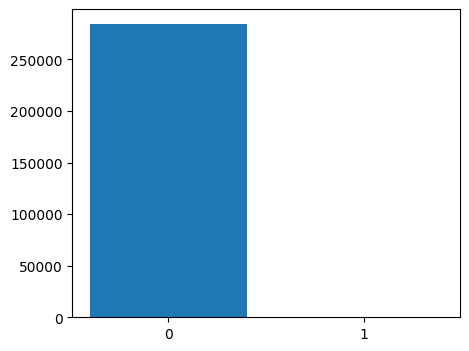

y=0: 284315 times
y=1: 492 times


In [ ]:
#distribution of the target variable

plt.figure(figsize=(5,4))
uns,counts = np.unique(y, return_counts=True)
plt.bar(uns,counts)
plt.xticks([0,1])
plt.show()

show_counts(y)

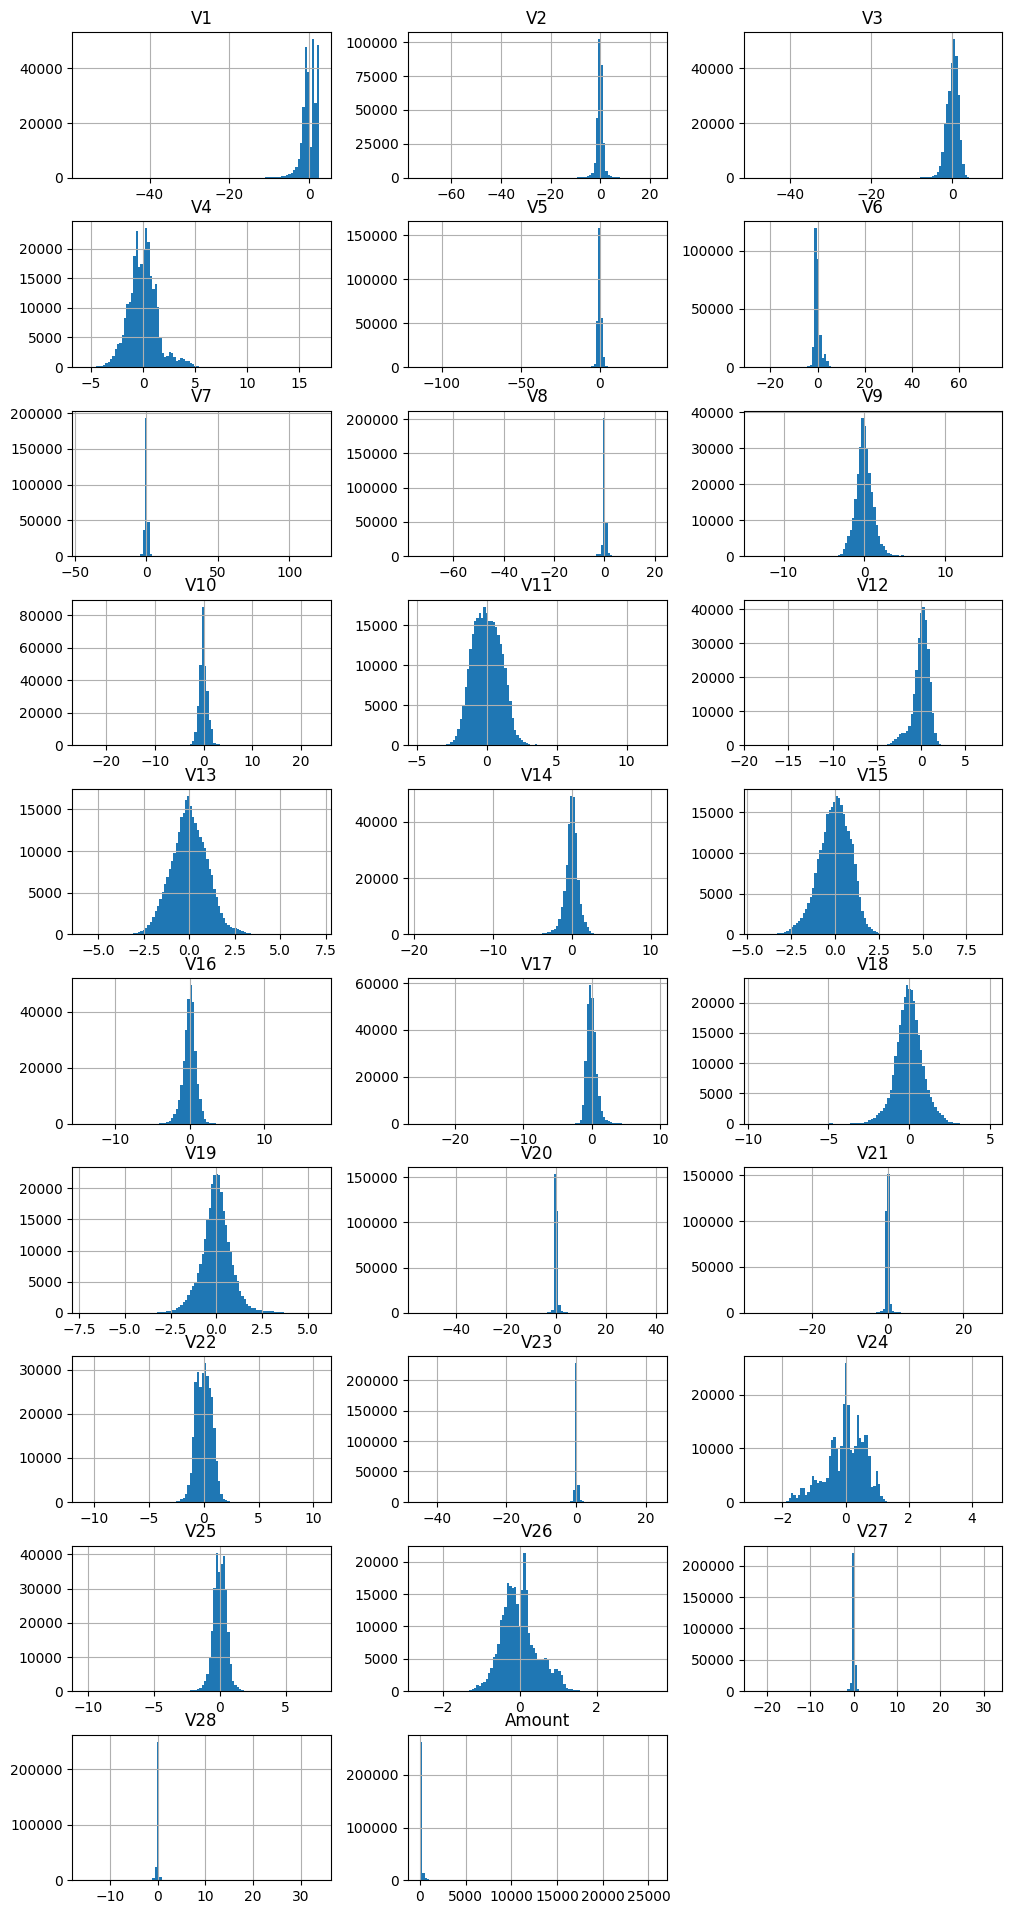

In [ ]:
df.hist(figsize=(12,24), bins=100, layout=(-1,3));

In [ ]:
df.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000
mean,1.759061e-12,-8.251130e-13,-9.654937e-13,8.321385e-13,1.649999e-13,4.248366e-13,-3.054600e-13,8.777971e-14,-1.179749e-12,7.092545e-13,...,1.766111e-12,-3.405756e-13,-5.723197e-13,-9.725856e-13,1.464150e-12,-6.987102e-13,-5.617874e-13,3.332082e-12,-3.518874e-12,88.349619
std,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,...,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109
min,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,...,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000
25%,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,...,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000
50%,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,...,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000
75%,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,...,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000
max,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,...,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000


In [ ]:
show_counts(y[df.Amount >= 50])

y=0: 94916 times
y=1: 187 times


In [ ]:
y

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
attribute_names = list(df.columns)
print(attribute_names)

['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


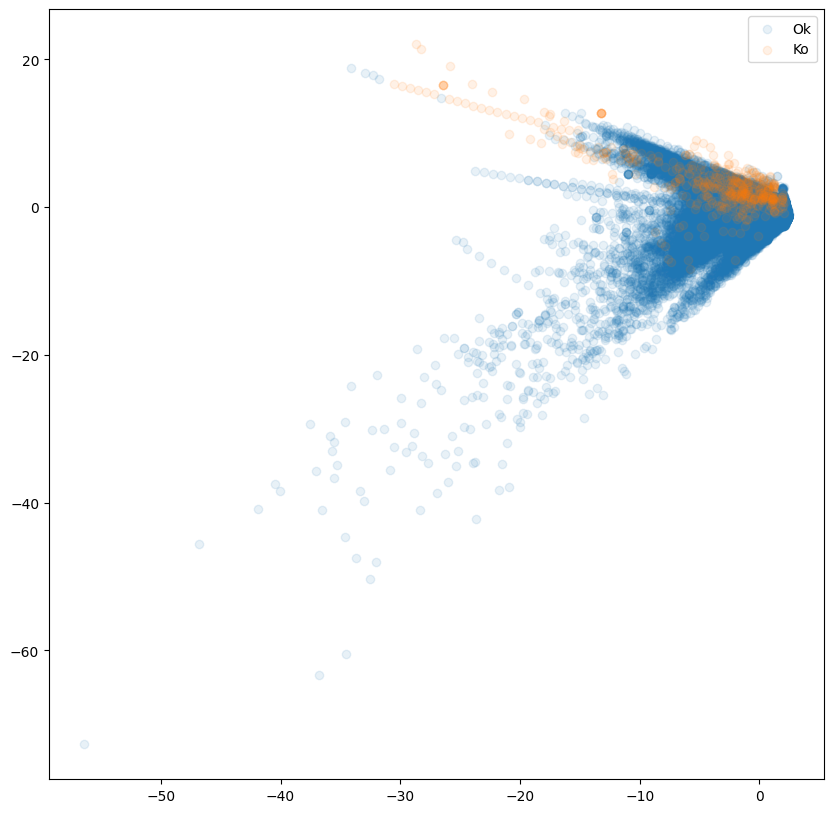

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(df[y==0]["V1"], df[y==0]["V2"], alpha=0.1, label="Ok")
plt.scatter(df[y==1]["V1"], df[y==1]["V2"], alpha=0.1, label="Ko")
plt.legend();

In [ ]:
df["Amount"] = df["Amount"] / 125

In [ ]:
df.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000
mean,1.759061e-12,-8.251130e-13,-9.654937e-13,8.321385e-13,1.649999e-13,4.248366e-13,-3.054600e-13,8.777971e-14,-1.179749e-12,7.092545e-13,...,1.766111e-12,-3.405756e-13,-5.723197e-13,-9.725856e-13,1.464150e-12,-6.987102e-13,-5.617874e-13,3.332082e-12,-3.518874e-12,0.706797
std,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,...,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,2.000961
min,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,...,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000
25%,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,...,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,0.044800
50%,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,...,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,0.176000
75%,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,...,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,0.617320
max,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,...,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,205.529280


## Partimos los datos en training y test

In [ ]:
df_tr, df_te, y_tr, y_te = train_test_split(df, y, test_size=0.3, random_state=2, stratify=y)

In [ ]:
y_tr.mean(), y_te.mean()

(0.0017254870488152324, 0.0017321489179921118)

In [ ]:
df_tr.shape

(199364, 29)

## Separación del dataset de entrenamiento en training y validación

Nota: al usar un autoencoder, en training solo hay transacciones no fraudulentas.

In [ ]:
# preparo conjunto de training y de validación
df_tr = df_tr[y_tr==0] # me quedo solo con los ejemplos ok
df_tr, df_val = train_test_split(df_tr, test_size=0.3, random_state=1) # el 30% lo llevo a validación

In [ ]:
df_tr.shape, df_val.shape

((139314, 29), (59706, 29))

## Definición del autoencoder con Keras/Tensorflow

In [ ]:
from tensorflow import keras

In [ ]:
# defino mi red como una lista de capas:

model = keras.Sequential(
    [
     keras.Input(29),
     keras.layers.Dense(10, activation="relu"),
     keras.layers.Dense(2, activation="relu"),
     keras.layers.Dense(10, activation="relu"),
     keras.layers.Dense(29)
    ]
)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                300       
                                                                 
 dense_1 (Dense)             (None, 2)                 22        
                                                                 
 dense_2 (Dense)             (None, 10)                30        
                                                                 
 dense_3 (Dense)             (None, 29)                319       
                                                                 
Total params: 671 (2.62 KB)
Trainable params: 671 (2.62 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(optimizer='rmsprop', loss="mse")

## Entrenamiento del modelo

In [ ]:
lista_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath="best_model.keras",
        monitor="val_loss",
        save_best_only=True,
    )
]

In [ ]:
historia = model.fit(df_tr, df_tr, batch_size=128, epochs=50, callbacks=lista_callbacks,
                     validation_data=(df_val, df_val))

Epoch 1/50
1089/1089 [==============================] - 3s 2ms/step - loss: 0.9886 - val_loss: 0.8026
Epoch 2/50
1089/1089 [==============================] - 2s 1ms/step - loss: 0.7982 - val_loss: 0.7678
Epoch 3/50
1089/1089 [==============================] - 2s 2ms/step - loss: 0.7741 - val_loss: 0.7408
Epoch 4/50
1089/1089 [==============================] - 2s 2ms/step - loss: 0.7349 - val_loss: 0.7034
Epoch 5/50
1089/1089 [==============================] - 2s 2ms/step - loss: 0.7129 - val_loss: 0.6915
Epoch 6/50
1089/1089 [==============================] - 3s 2ms/step - loss: 0.7042 - val_loss: 0.6840
Epoch 7/50
1089/1089 [==============================] - 2s 2ms/step - loss: 0.6971 - val_loss: 0.6777
Epoch 8/50
1089/1089 [==============================] - 2s 2ms/step - loss: 0.6897 - val_loss: 0.6723
Epoch 9/50
1089/1089 [==============================] - 2s 1ms/step - loss: 0.6840 - val_loss: 0.6660
Epoch 10/50
1089/1089 [==============================] - 2s 2ms/step - loss: 0.679

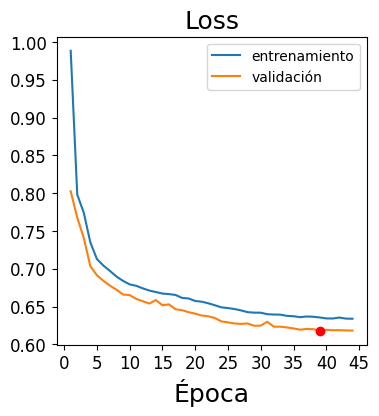

In [ ]:
plot_history(historia)

## Chequeo del autoencoder entrenado

In [ ]:
# cargo best_model de fichero, que es el punto rojo (donde mejor métrica en validación)
model = keras.models.load_model("best_model.keras")

In [ ]:
df_te[:3]

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
112855,-1.142801,1.409180,-0.646741,-1.254767,2.420123,3.376525,-0.204954,0.135930,0.019185,0.357833,...,0.273384,0.391299,-1.307445,0.115663,0.913466,0.111612,0.092952,0.369318,0.217595,0.01432
262809,-1.088132,0.744172,0.761392,-0.861099,0.905130,-0.386599,1.162297,-0.066910,-0.211388,-0.639000,...,0.040266,-0.319960,-0.900011,-0.310377,0.469027,0.699531,0.390946,0.075354,0.110781,0.46752
106017,-9.156731,-1.036810,-4.665348,4.390102,-6.271095,2.299906,0.001721,3.595945,-2.478871,-0.943510,...,-1.961031,0.012017,-0.756726,-2.000589,-0.027954,-1.011416,-0.178245,-1.274012,-1.466693,3.94328


In [ ]:
errores_totales = ((df_te.values - model.predict(df_te))**2).mean(axis=1)
errores_totales.shape

2671/2671 [==============================] - 3s 963us/step


(85443,)

In [ ]:
df_te.shape

(85443, 29)

In [ ]:
inds = np.argsort(errores_totales)[::-1] # saco los índices de los errores de mayor a menor magnitud

In [ ]:
np.argsort([5,4,3])[::-1]

array([0, 1, 2])

In [ ]:
y_te[inds[:20]]

array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1])

In [ ]:
errores_totales[:100]

array([0.49670879, 0.24549312, 6.44752952, 0.18009559, 0.55037255,
       0.12475825, 0.95703936, 0.40337545, 0.71330209, 0.46986351,
       0.30814189, 0.29547104, 1.44013834, 0.36746843, 0.19189271,
       0.2543172 , 0.82322162, 0.24901509, 0.94479593, 0.22340031,
       1.25357219, 1.08324589, 0.35132437, 0.91791217, 0.53404432,
       1.28024248, 1.32410406, 0.76390095, 0.15618211, 1.11445497,
       0.88796396, 0.43783886, 0.36135016, 0.58483811, 0.24234046,
       0.30893963, 0.9524338 , 1.29061559, 0.19209067, 0.63863039,
       0.33220834, 1.57538613, 0.85497438, 0.50432787, 0.76744574,
       0.24214844, 1.30301598, 0.9444173 , 0.35857925, 0.66932871,
       0.28742527, 0.29788462, 0.61478642, 0.35864633, 0.13232999,
       0.32181981, 0.2803006 , 0.92983857, 0.19769065, 0.23232115,
       0.2859786 , 0.46709486, 0.91099723, 0.59311184, 0.45033669,
       0.3300555 , 0.1429139 , 0.76654104, 0.33811411, 0.63937699,
       0.20917442, 0.67566112, 0.7646547 , 0.7676199 , 0.15473

In [ ]:
y_te[-401:-375]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0])

In [ ]:
errores_totales[-401:-375]

array([ 8.30756056,  0.35613416,  0.983687  ,  0.19121608,  0.8675731 ,
        0.16688604,  0.20456572,  0.63633873,  0.36092411,  0.80941135,
        0.3062563 ,  0.27910721,  0.93014297,  0.26609623,  0.24629303,
        0.63305651,  0.24816213,  0.25005586,  0.29179597,  0.37945253,
        0.8716027 ,  0.13784404,  2.58213351, 61.04041418,  0.43484521,
        0.78786378])

In [ ]:
tabla_test = pd.DataFrame({"clase_real":y_te, "error_autoencoder":errores_totales})
tabla_test.sort_values("error_autoencoder", ascending=False)[:20]

,clase_real,error_autoencoder
49313,1,170.040628
46402,0,146.965848
20582,1,134.617889
84304,1,117.304420
72754,1,117.304420
7432,1,108.411173
23383,1,108.411173
77734,1,107.624522
80444,1,80.858636
58324,1,75.718088


## Curva ROC

In [ ]:
fpt, tpr, thresholds = roc_curve(y_true=y_te, y_score=errores_totales, pos_label=1)

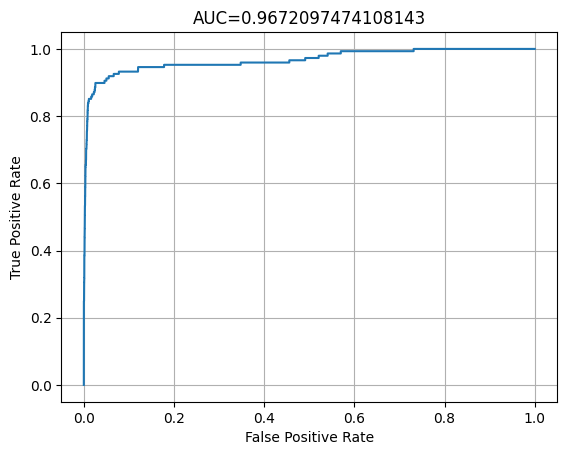

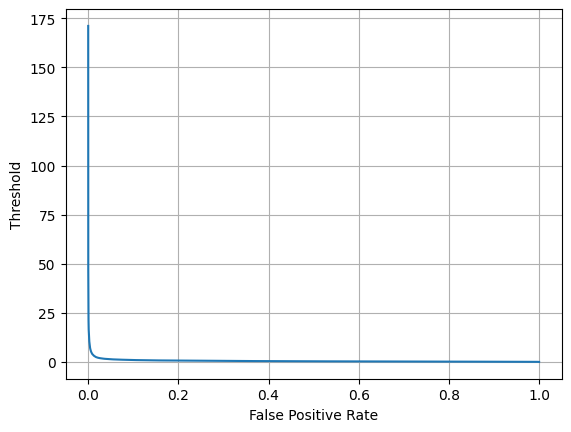

In [ ]:
plt.plot(fpt, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC={}".format(roc_auc_score(y_true=y_te, y_score=errores_totales)))
plt.grid()
plt.show()

plt.plot(fpt, thresholds)
plt.xlabel("False Positive Rate")
plt.ylabel("Threshold")
plt.grid();

## Curva Precision-Recall

In [ ]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_te, errores_totales, pos_label=1)

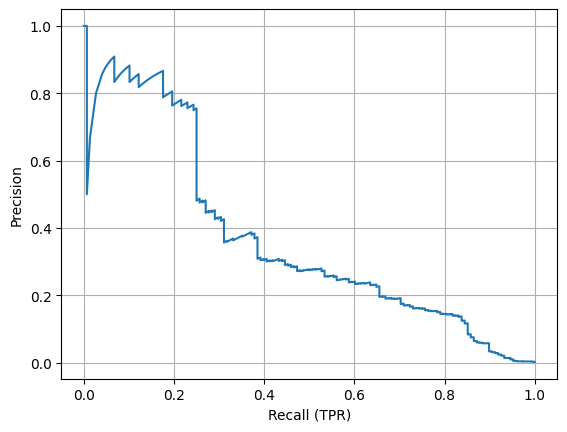

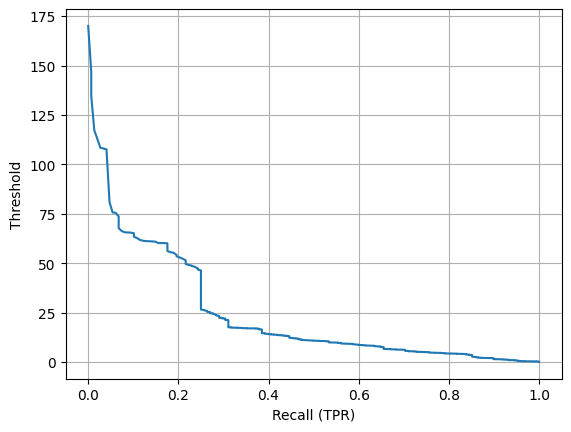

In [ ]:
plt.plot(recall, precision)
plt.xlabel("Recall (TPR)")
plt.ylabel("Precision")
plt.grid()
plt.show()
plt.plot(recall[1:], thresholds)
plt.xlabel("Recall (TPR)")
plt.ylabel("Threshold")
plt.grid();